# Experiment on the Diabetes Dataset

In this notebook, we conduct experiments on the Diabetes dataset. The goal is to predict whether a patient has diabetes or not (outcome = 1 or outcome = 0). To achieve this, we implement a Neural Network with Dropout layers in order to measure the uncertainty of the predictions by conducting different forward passes, each producing a different output. In this way, Dropout Regularization serves as an approximation of a Bayesian Neural Network.

In [76]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from xgboost import XGBClassifier

## Data Preprocessing

Our variable of interest is the 'Outcome' variable. In order to visually explore the uncertainties obtained, we need to reduce the input dimension to 2. Therefore, we choose the two most important variables. To achieve this, we can either select them using the Feature Importance method of XGBoost, a gradient-boosting classifier, or choose the two most correlated variables with the outcome.

In [77]:
df = pd.read_csv('diabetes.csv')
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [78]:
# Making sure there are no 'Nan's
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [79]:
X, y = df.drop(columns='Outcome'), df['Outcome']

First, we plot the correlation matrix of our dataset.

Variables les plus corrélées avec Outcome :
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


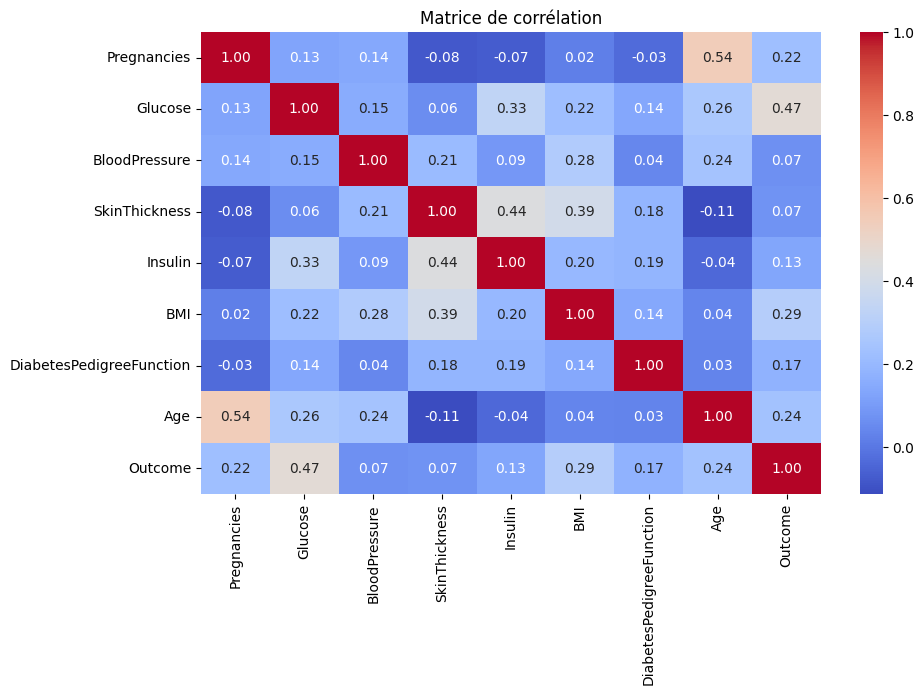

In [80]:
correlations = df.corr()


outcome_corr = correlations['Outcome'].drop('Outcome').sort_values(ascending=False)


plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


The two most correlated variables with the outcome variable are: 'Glucose' and 'BMI'. Now, we plot the feature importance according to a XGBoost classifier that performs our binary classification task.

                    Feature  Importance
1                   Glucose    0.269498
5                       BMI    0.151984
7                       Age    0.135391
6  DiabetesPedigreeFunction    0.101782
2             BloodPressure    0.093568
3             SkinThickness    0.090205
4                   Insulin    0.082889
0               Pregnancies    0.074684


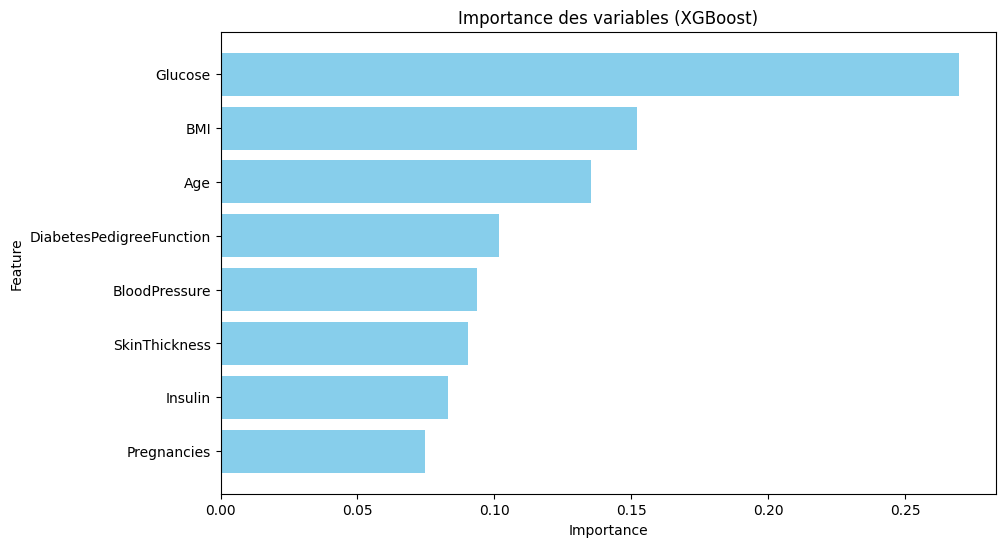

In [81]:
# Initialize classifier
model = XGBClassifier(random_state=42)
model.fit(X, y) # Fit the model

# Get feature importances
importances = model.feature_importances_
features = X.columns


feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


print(feature_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importance des variables (XGBoost)')
plt.gca().invert_yaxis()  # Inverser l'ordre pour que les plus importantes soient en haut
plt.show()

Again, we observe that 'Glucose' and 'BMI' are the most important variables, as they contributed the most to increasing the score or decreasing the loss compared to other features.

Now, we plot the outcome scatter points as a function of both these features.

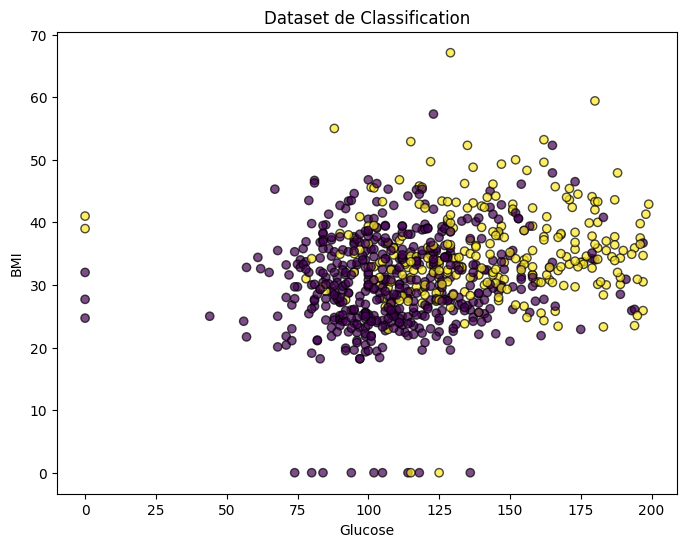

In [82]:
X, y = df[['Glucose', 'BMI']], df['Outcome']

# Convertir en tensor pour PyTorch
X_tensor = torch.tensor(X.values).type(torch.float)
y_tensor = torch.tensor(y.values).type(torch.long)

# Visualiser le dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Outcome")
plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.show()

We observe the presence of some outliers (Glucose=0 or BMI=0). We delete them in the following cell.

In [83]:
# Filter dataset by deleting outliers
mask = (X['Glucose'] != 0) & (X['BMI'] != 0)

# Applying masks
X = X[mask]
y = y[mask]

X_tensor = torch.tensor(X.values, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.long)

We also perform a PCA to visualize the scatter points of the outcome as a function of two latent dimensions. Unfortunately, we observe no clusters.

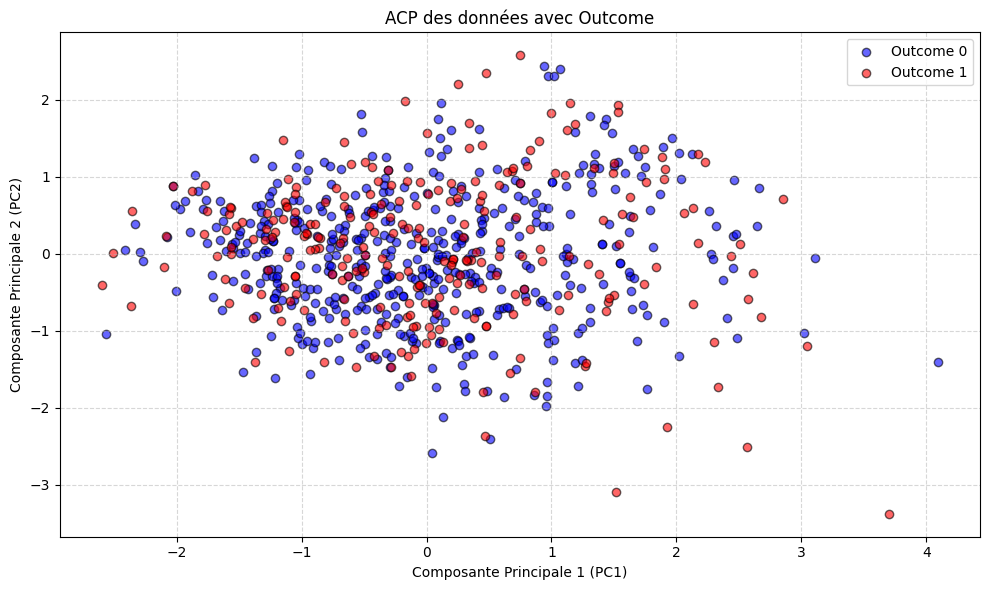

In [84]:
# Standardizing inputs for the PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA(n_components=2)  # Réduire à 2 dimensions pour la visualisation
X_pca = pca.fit_transform(X_scaled)


pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Outcome'] = y

# Visualization
plt.figure(figsize=(10, 6))
colors = {0: 'blue', 1: 'red'}
for label, color in colors.items():
    subset = pca_df[pca_df['Outcome'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Outcome {label}', color=color, alpha=0.6, edgecolor='k')

plt.title('PCA with the Outcome')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Model Inference

Now, we implement our Neural Network with Dropout layers and perform inference on our training set. For now, our goal is to visualize model uncertainty. It is acceptable to do this on the training set first. In our other experiment on the PMJE dataset, we visualize our uncertainty on a test set. First, we perform inference with our model and plot the entropy using the probabilities returned by the sigmoid function applied to the logits produced by the MLP.

In [85]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.2):
        super(MLPWithDropout, self).__init__()
        
        hidden_dims = [input_dim] + hidden_dims

        self.layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Sequential(
            nn.Linear(hidden_dims[i-1], hidden_dims[i]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)))

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

# Initialize model
model = MLPWithDropout(input_dim=2, hidden_dims=[64, 32], output_dim=2)

For our binary classification task, entropy is calculated based on the predicted probabilities for each class. When the model is uncertain (i.e., when the probabilities are close to 0.5), entropy is high, and when the model is confident (i.e., when the probabilities are close to 0 or 1), entropy is low. High entropy indicates more uncertainty, while low entropy indicates more certainty in the prediction.

In [86]:
# Entropy function

def get_entropy(prob: torch.Tensor):
    entropy = - prob * torch.log(prob) - (1 - prob) * torch.log(1 - prob)
    entropy[entropy != entropy] = 0  # nan to zero
    entropy = entropy.detach().cpu().numpy()
    return entropy

In [87]:
epochs = 2000
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Run training
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    output = model(X_tensor)  

    
    target_one_hot = torch.zeros(X_tensor.size(0), 2) 
    target_one_hot[torch.arange(X_tensor.size(0)), y_tensor] = 1 
    
    # Computing the loss
    loss = nn.BCEWithLogitsLoss()(output, target_one_hot)
    
    # Computing gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printing the loss at each epoch
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")


Epoch 1/2000 - Loss: 4.381836
Epoch 2/2000 - Loss: 3.530516
Epoch 3/2000 - Loss: 2.216364
Epoch 4/2000 - Loss: 2.015929
Epoch 5/2000 - Loss: 1.763166
Epoch 6/2000 - Loss: 1.459654
Epoch 7/2000 - Loss: 1.135876
Epoch 8/2000 - Loss: 0.963638
Epoch 9/2000 - Loss: 0.857416
Epoch 10/2000 - Loss: 0.837486
Epoch 11/2000 - Loss: 0.818642
Epoch 12/2000 - Loss: 0.770676
Epoch 13/2000 - Loss: 0.753997
Epoch 14/2000 - Loss: 0.719973
Epoch 15/2000 - Loss: 0.718179
Epoch 16/2000 - Loss: 0.706475
Epoch 17/2000 - Loss: 0.702715
Epoch 18/2000 - Loss: 0.700063
Epoch 19/2000 - Loss: 0.699002
Epoch 20/2000 - Loss: 0.696225
Epoch 21/2000 - Loss: 0.695499
Epoch 22/2000 - Loss: 0.696366
Epoch 23/2000 - Loss: 0.693135
Epoch 24/2000 - Loss: 0.691794
Epoch 25/2000 - Loss: 0.693170
Epoch 26/2000 - Loss: 0.689172
Epoch 27/2000 - Loss: 0.689832
Epoch 28/2000 - Loss: 0.684127
Epoch 29/2000 - Loss: 0.685616
Epoch 30/2000 - Loss: 0.679123
Epoch 31/2000 - Loss: 0.679199
Epoch 32/2000 - Loss: 0.675518
Epoch 33/2000 - L

We now visualize the decision boundary and entropy of our model after training.

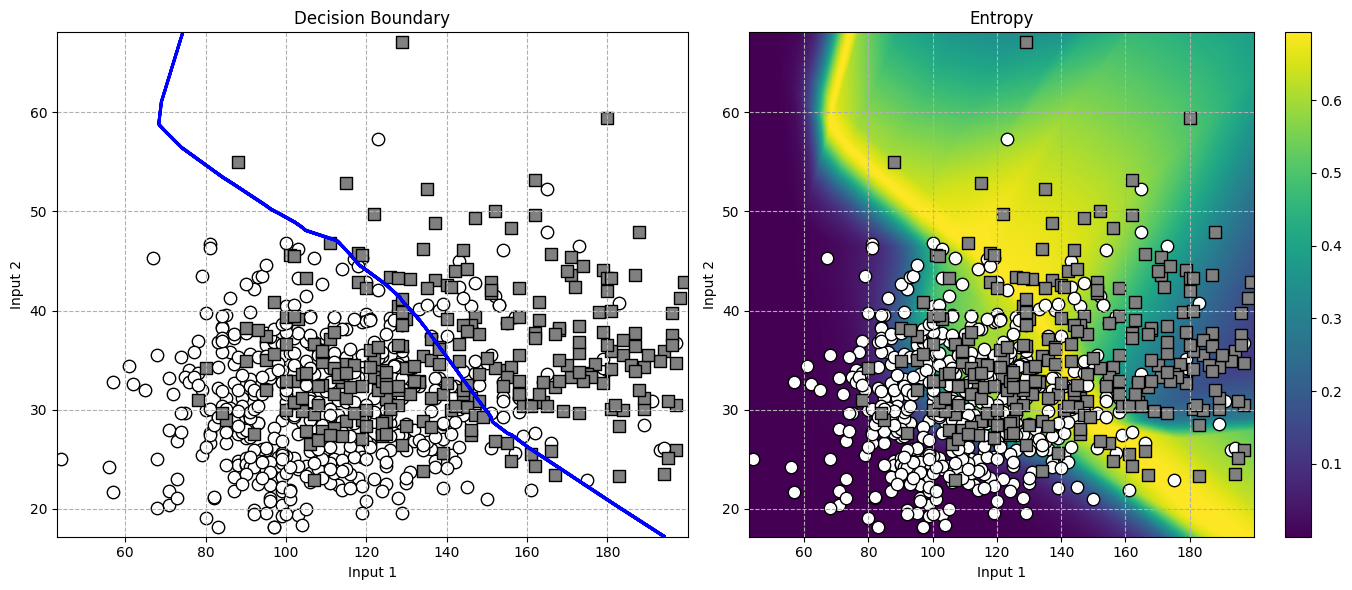

In [91]:
# Evaluation Grid
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)


fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

# Decision boundary
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlabel("Input 1")
ax1.set_ylabel("Input 2")
ax1.set_title("Decision Boundary")

# Entropy
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlabel("Input 1")
ax2.set_ylabel("Input 2")
ax2.set_title("Entropy")

# Evaluation mode to perform inference on the whole grid
model.eval()

# Décision et entropie pour la visualisation
output = model(data_meshgrid)  # Logits pour chaque point
prob = torch.softmax(output, dim=1)  # Probabilités pour chaque classe
prob_class_1 = prob[:, 1].view(xx.shape)  # Probabilité pour la classe 0
entropy = get_entropy(prob_class_1)  # Entropie basée sur les probabilités
pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # Classe prédite

# Affichage de la frontière de décision
ax1.contour(xx, yy, pred, colors=["blue"], linewidths=[2])

# Affichage de l'entropie
im = ax2.pcolormesh(xx, yy, entropy)  # Affichage de l'entropie
fig.colorbar(im, ax=ax2)

# Points de données (assurez-vous que y est une série ou un tenseur avec les bonnes dimensions)
for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
    _X = X[y == label]  # Filtrer les points par classe
    ax1.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)  # X est un DataFrame
    ax2.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)

ax1.grid(linestyle="--")
ax2.grid(linestyle="--")
plt.tight_layout()
plt.show()  # Affichage final du plot

We observe that the data is too complex to have an acceptable decision boundary. Moreover, the entropy is high in some zones, which we can interpret as uncertainty (with probabilities close to one-half).

## Model Uncertainty

Plotting the entropy for a simple MLP is not enough, especially when dropout was not activated earlier (deterministic model). To interpret the true model uncertainty, we need to perform several forward passes with dropout activated, allowing for different outputs each time, and visualize the decision boundaries at each iteration (forward pass).



In [ ]:
# Function to activate dropout even in evaluation mode
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

tensor([[ 17.1709, -17.0969],
        [ 14.3661, -14.1805],
        [ 14.4869, -14.3277],
        ...,
        [ -1.6364,   1.6458],
        [ -1.2046,   1.2125],
        [ -0.3078,   0.3104]], grad_fn=<AddmmBackward0>)


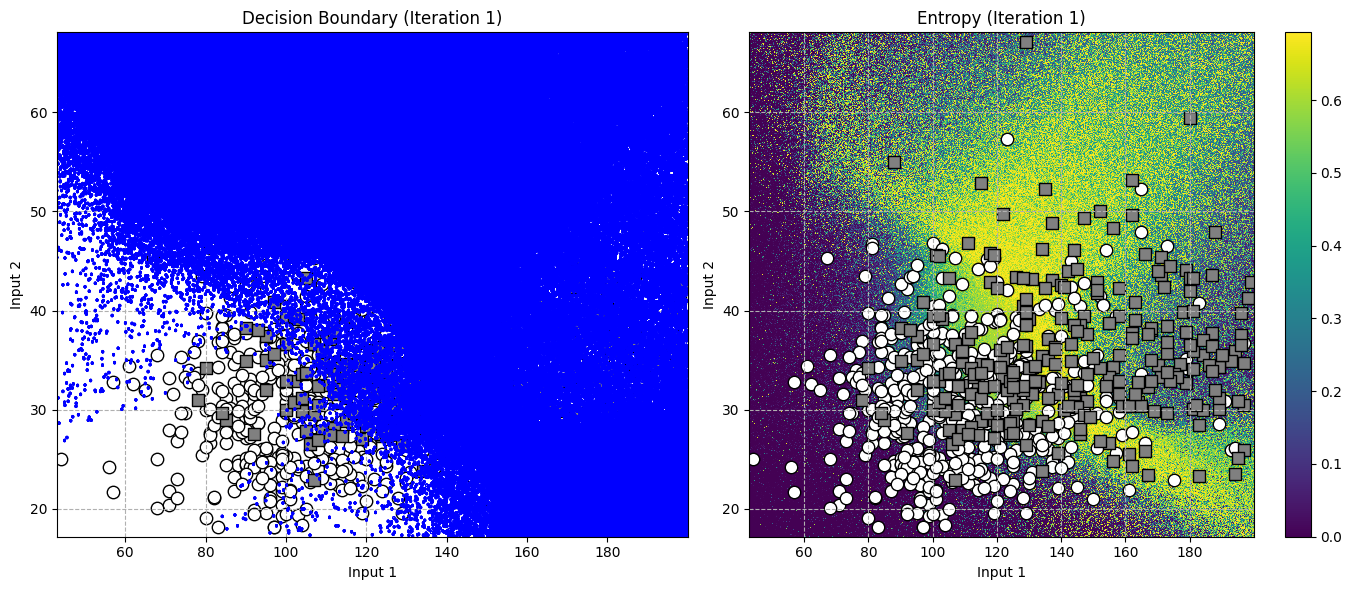

tensor([[ 17.1296, -17.0638],
        [ 14.9104, -14.6582],
        [ 14.8002, -14.6531],
        ...,
        [ -1.6581,   1.6678],
        [ -0.4437,   0.4499],
        [ -0.1875,   0.1900]], grad_fn=<AddmmBackward0>)


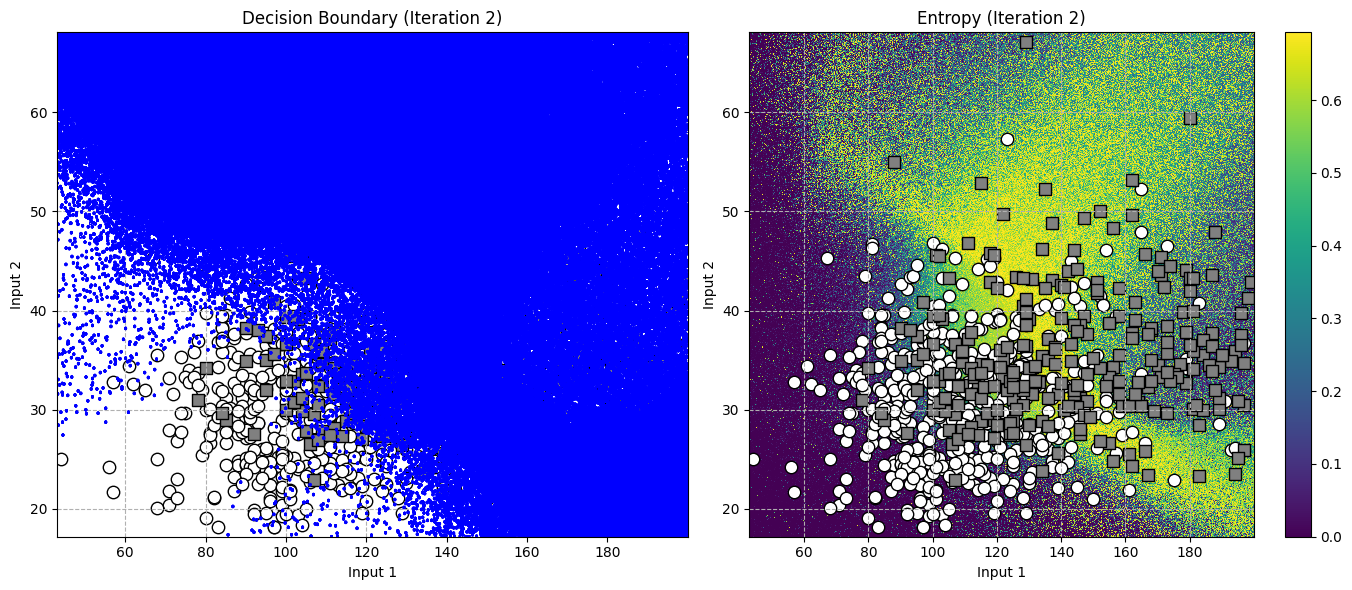

tensor([[  7.7971,  -7.7618],
        [  6.7568,  -6.6395],
        [ 17.3395, -17.1146],
        ...,
        [ -1.1043,   1.1117],
        [ -0.5568,   0.5635],
        [ -1.8958,   1.9064]], grad_fn=<AddmmBackward0>)


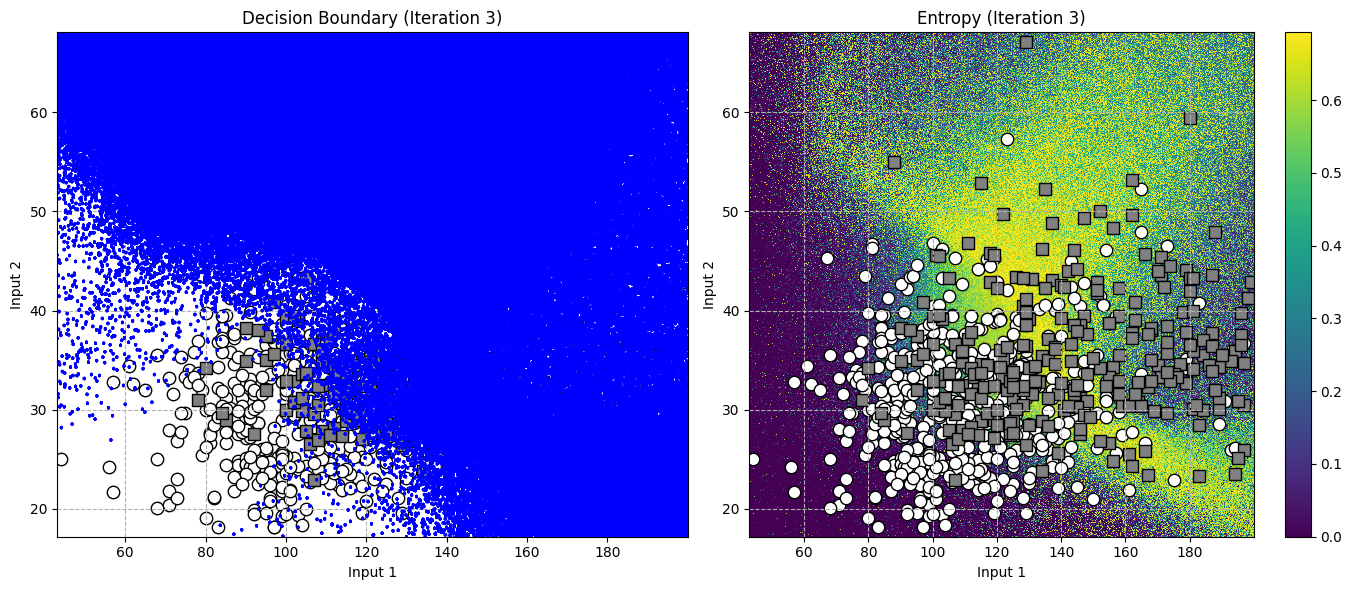

tensor([[  2.9652,  -2.9471],
        [ 14.8433, -14.6703],
        [ 10.0732, -10.1496],
        ...,
        [ -0.4916,   0.4980],
        [ -1.2502,   1.2584],
        [ -1.0635,   1.0706]], grad_fn=<AddmmBackward0>)


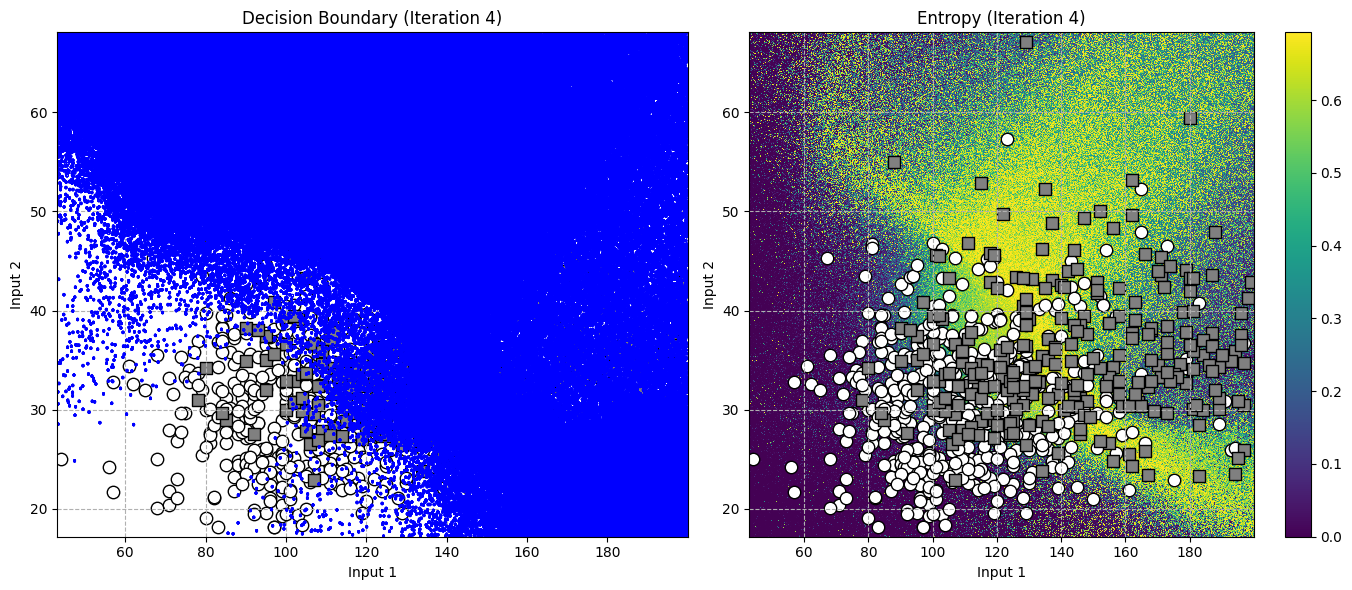

tensor([[  8.2306,  -8.0972],
        [  7.5879,  -7.6878],
        [ 14.8614, -14.6419],
        ...,
        [ -0.2583,   0.2609],
        [ -0.5252,   0.5317],
        [ -1.5499,   1.5592]], grad_fn=<AddmmBackward0>)


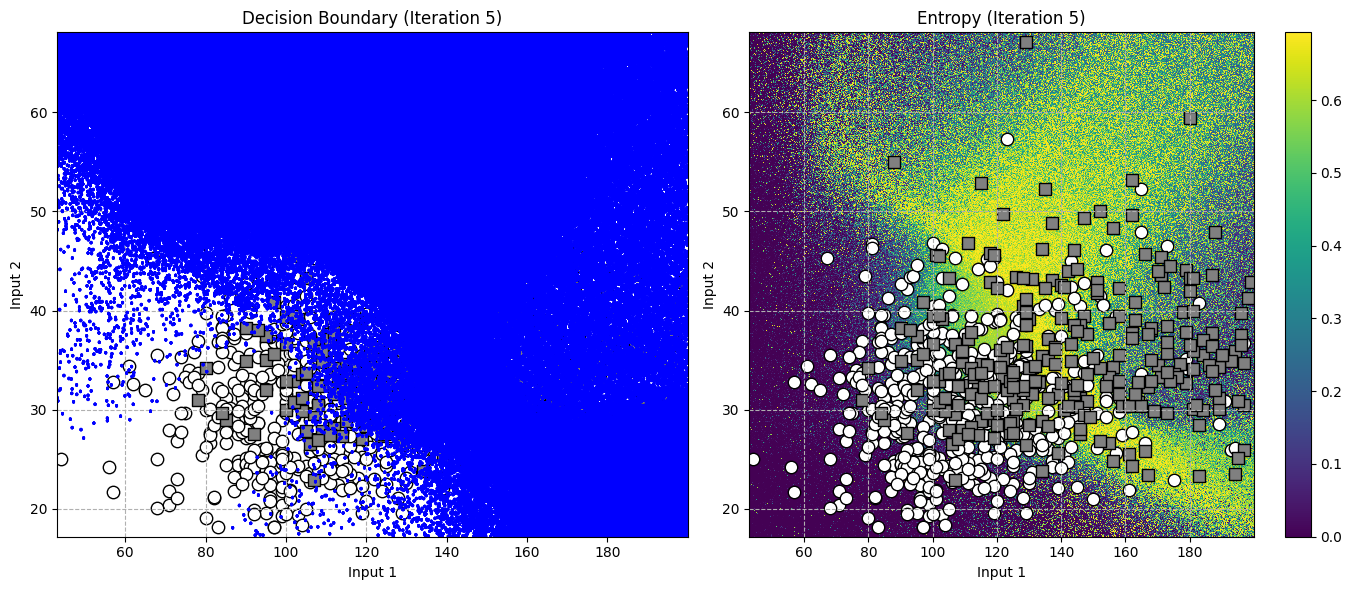

In [90]:
# Définir les limites de la grille en fonction de vos données
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)

# Activer le dropout en mode évaluation
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

model.eval()
enable_dropout(model)

# Nombre de passes pour MC Dropout
num_passes = 5

# Effectuer plusieurs passes pour obtenir les prédictions
for i in range(num_passes):
    output = model.forward(data_meshgrid)  # Logits pour chaque point
    print(output)
    prob = torch.softmax(output, dim=1)  # Probabilités pour chaque classe
    prob_class_1 = prob[:, 1].view(xx.shape)  # Probabilité pour la classe 1
    pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # Classe prédite
    entropy = get_entropy(prob_class_1)  # Calcul de l'entropie

    # Créer un graphique pour l'itération actuelle
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Affichage de la frontière de décision
    ax1.contour(xx, yy, pred, colors=["blue"], linewidths=[2])
    ax1.set_xlabel("Input 1")
    ax1.set_ylabel("Input 2")
    ax1.set_title(f"Decision Boundary (Iteration {i + 1})")

    # Affichage de l'entropie
    im = ax2.pcolormesh(xx, yy, entropy, shading="auto")
    fig.colorbar(im, ax=ax2)
    ax2.set_xlabel("Input 1")
    ax2.set_ylabel("Input 2")
    ax2.set_title(f"Entropy (Iteration {i + 1})")

    # Points de données
    for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
        _X = X[y == label]  # Filtrer les points par classe
        ax1.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)
        ax2.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)

    ax1.grid(linestyle="--")
    ax2.grid(linestyle="--")
    plt.tight_layout()
    plt.show()  # Afficher le graphique pour l'itération actuelle



The data is too complex to be able to view a correct decision boundary. Here, the dropout has only increased noise in our predictions in some way. We need more simple data to be able to test our model for uncertainty visualization. In our synth_exp.ipynb notebook, we perfom the same experiment on linearly separable synthetized data.